<a href="https://colab.research.google.com/github/jgait/DSPS_WGaither/blob/main/lab10-23/Gaussian_Process_Regression_WFF_23Oct2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1415)

# Generate Synthetic Dataset

In [19]:
def gen_synthetic_data(nSynth, theta):

    # Generate synthetic sample points between -1 and 1.
    X  = rng.uniform(low=-1, high=1, size=nSynth)
    # X = np.linspace(-1, 1, num=nSynth)

    # Generate stochastic Gaussian noise for each sample.
    E = np.abs(rng.normal(loc=0, scale=0.25, size=nSynth))
    # E *= 0.00001

    # Use Kernel function to make covariance matrix.
    K = rbf_kernel(X, X, theta)

    # A diagnoal matrix containing the stochastic Gaussian noise.
    W = white_noise_kernel(E)

    # C + W is the covariance matrix of the posterior distribution. Sample from it at mean 0.
    Y = rng.multivariate_normal(np.zeros(nSynth), K + W)

    return X, Y, E, K, W


def rbf_kernel(X1, X2, theta):
    uu, vv = np.meshgrid(X1, X2)
    return np.exp(-(vv - uu)**2 / (2 * theta**2))


def white_noise_kernel(E):
    return np.diag(E**2)

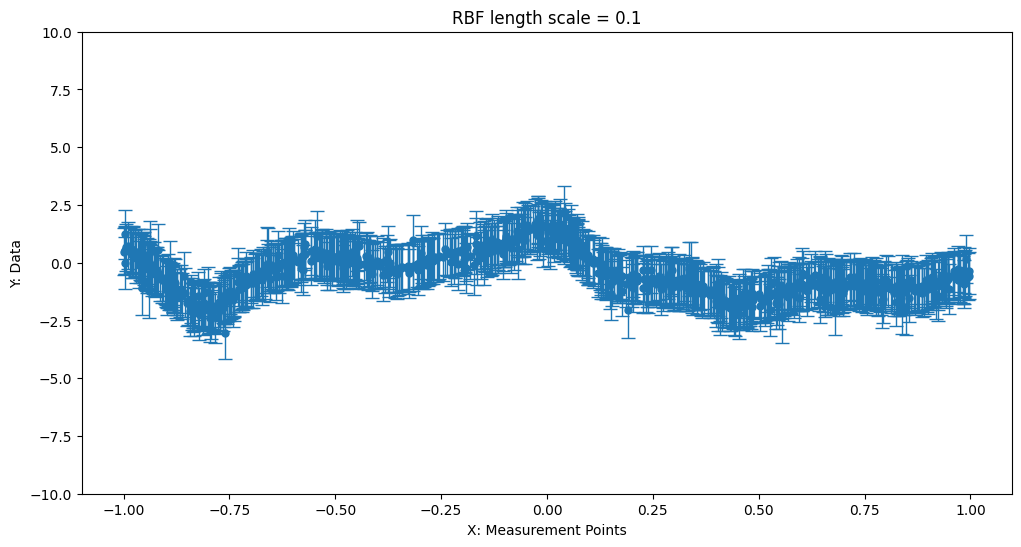

In [20]:
theta = 0.1
nSynth = 1000
X, Y, E, K_true, W = gen_synthetic_data(nSynth, theta)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"RBF length scale = {theta}")

ax.errorbar(
    X, Y,
    yerr=np.sqrt(np.diag(K_true+W)),
    ls="", marker="o", ms=5,
    elinewidth=1, capsize=5,
    )

ax.set_ylim(-10, 10)
ax.set_xlabel("X: Measurement Points")
ax.set_ylabel("Y: Data")
fig.show()

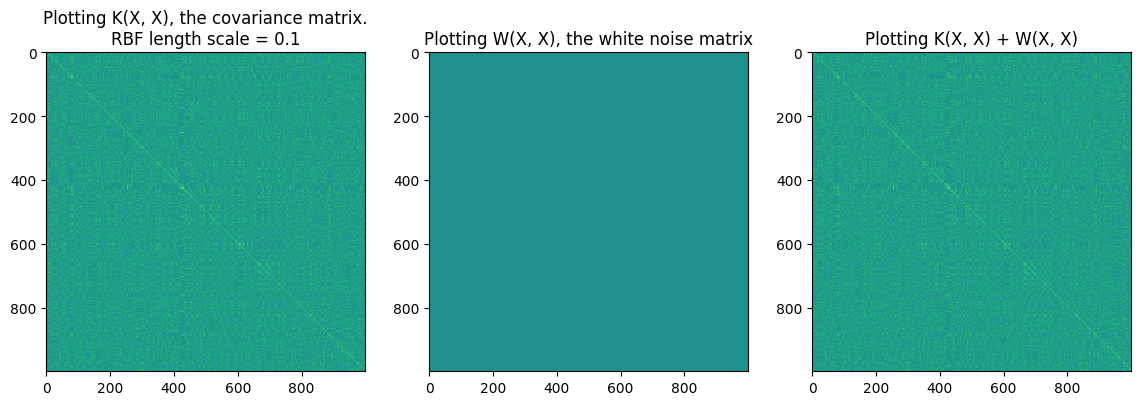

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

ax[0].set_title(f"Plotting K(X, X), the covariance matrix.\nRBF length scale = {theta}")
ax[0].imshow(K_true, vmin=-1, vmax=1)

ax[1].set_title("Plotting W(X, X), the white noise matrix")
ax[1].imshow(W, vmin=-1, vmax=1)

ax[2].set_title("Plotting K(X, X) + W(X, X)")
ax[2].imshow(K_true + W, vmin=-1, vmax=1)

fig.show()

# Learn about Gaussian process fitting

In [22]:
Xtrn, Xtst, Ytrn, Ytst, Etrn, Etst = train_test_split(X, Y, E, train_size=0.05, random_state=rng, shuffle=True)

print(Xtrn.shape, Ytrn.shape, Etrn.shape)
print(Xtst.shape, Ytst.shape, Etst.shape)

num_trn = Xtrn.shape[0]
num_tst = Xtst.shape[0]

(50,) (50,) (50,)
(950,) (950,) (950,)


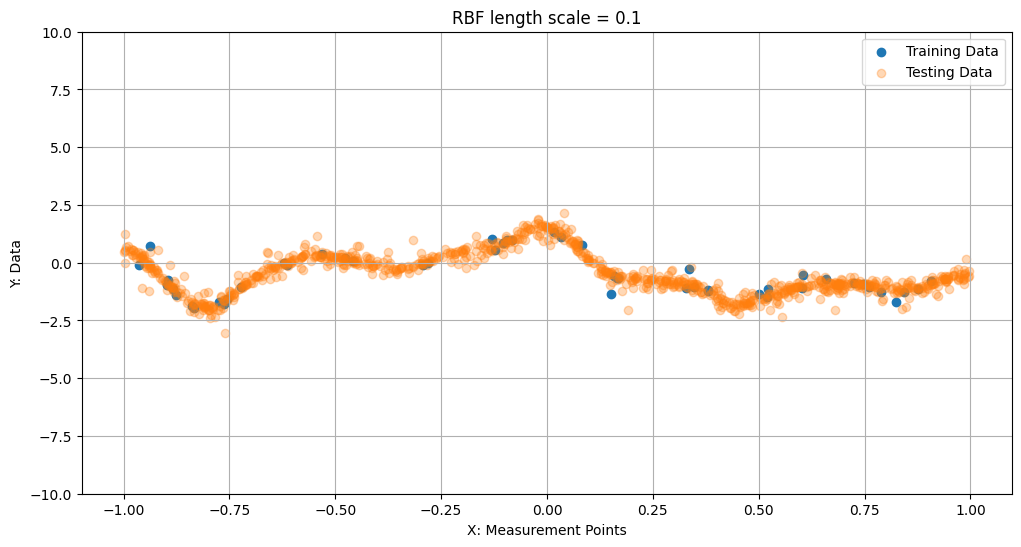

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"RBF length scale = {theta}")

ax.scatter(Xtrn, Ytrn, label="Training Data")
ax.scatter(Xtst, Ytst, label="Testing Data", alpha=0.30)

ax.set_ylim(-10, 10)
ax.set_xlabel("X: Measurement Points")
ax.set_ylabel("Y: Data")
ax.legend()
ax.grid()
fig.show()

In [24]:
def fit_GP(Xtrn, Etrn, Ytrn, num_tst, theta):
    K = rbf_kernel(Xtrn, Xtrn, theta)
    W = white_noise_kernel(Etrn)

    L = np.linalg.cholesky(K + W)

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, Ytrn))
    nLML = -((-1/2) * np.dot(Ytrn, alpha) - np.sum(np.log(np.diag(L))) - (num_tst / 2) * np.log(2 * np.pi))

    return K, W, L, alpha, nLML


def predict_GP(Xtrn, Xprd, K, W, L, alpha, nLML):
    Ks = rbf_kernel(Xprd, Xtrn, theta)
    fbar_s = np.dot(Ks.T, alpha)

    Kss = rbf_kernel(Xprd, Xprd, theta)
    v = np.linalg.solve(L, Ks)
    V_s = Kss - np.dot(v.T, v)
    sigma = np.sqrt(np.abs(np.diag(V_s)))

    return Ks, fbar_s, Kss, v, V_s, sigma

In [25]:
theta_guess = 0.1

# Fit model
Ktrn, Wtrn, L, alpha, nLML = fit_GP(Xtrn, Etrn, Ytrn, num_tst, theta_guess)
print(Ktrn.shape, Wtrn.shape, L.shape, alpha.shape, nLML)

(50, 50) (50, 50) (50, 50) (50,) 840.2012986207454


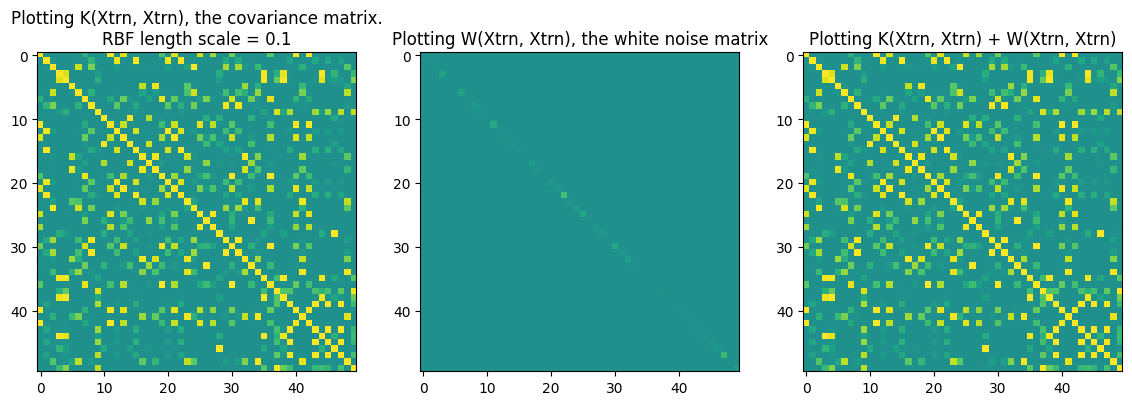

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

ax[0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0].imshow(Ktrn,
             vmin=-1, vmax=1
             )

ax[1].set_title("Plotting W(Xtrn, Xtrn), the white noise matrix")
ax[1].imshow(Wtrn,
             vmin=-1, vmax=1
             )

ax[2].set_title("Plotting K(Xtrn, Xtrn) + W(Xtrn, Xtrn)")
ax[2].imshow(Ktrn + Wtrn,
             vmin=-1, vmax=1
             )

fig.show()

In [27]:
Ks, fbar_s, Kss, v, V_s, sigma = predict_GP(Xtrn, Xtst, Ktrn, Wtrn, L, alpha, nLML)
Ks.shape, fbar_s.shape, Kss.shape, v.shape, V_s.shape, sigma.shape

((50, 950), (950,), (950, 950), (50, 950), (950, 950), (950,))

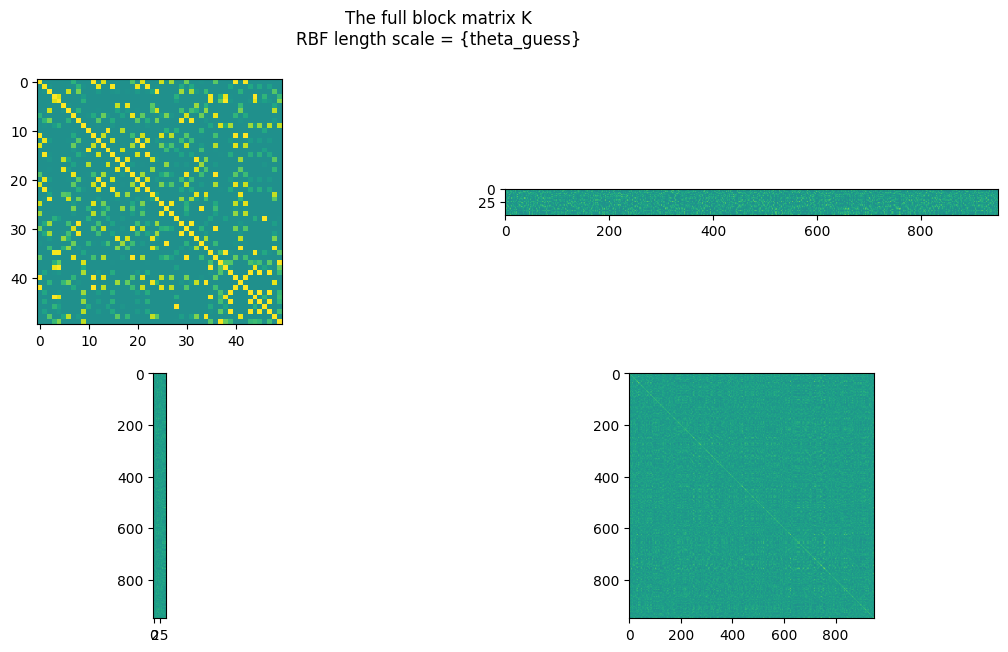

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

# ax[0, 0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0, 0].imshow(Ktrn, vmin=-1, vmax=1)

# ax[0, 1].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[0, 1].imshow(Ks, vmin=-1, vmax=1)

# ax[1, 0].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[1, 0].imshow(Ks.T, vmin=-1, vmax=1)

# ax[1, 1].set_title(f"Plotting K(Xtrn, Xtrn), the covariance matrix.\nRBF length scale = {theta_guess}")
ax[1, 1].imshow(Kss, vmin=-1, vmax=1)

fig.suptitle("The full block matrix K\nRBF length scale = {theta_guess}")

fig.show()

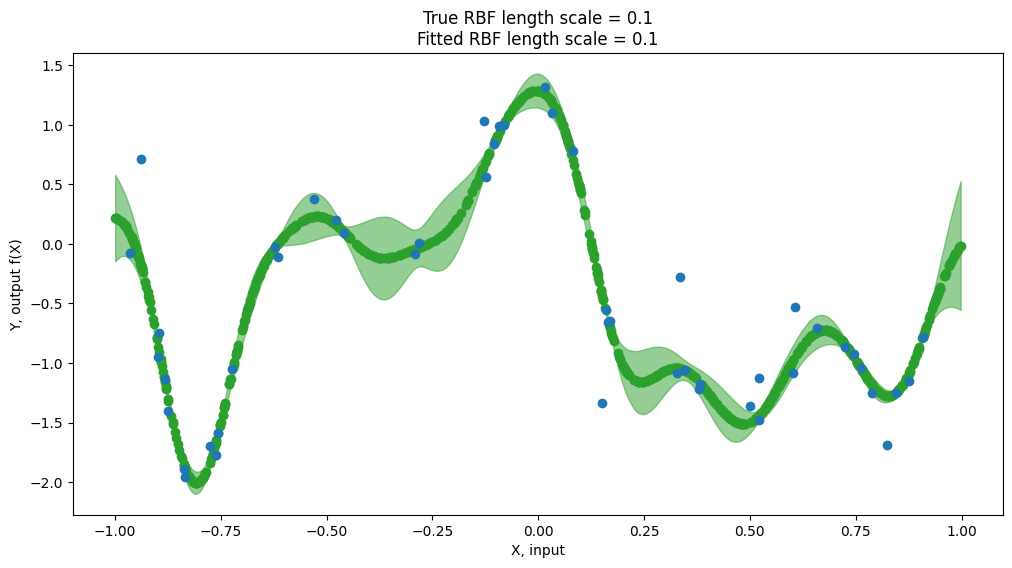

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"True RBF length scale = {theta}\nFitted RBF length scale = {theta_guess}")

# ax.scatter(Xtrn, Ytrn, label="Training Data", c="tab:blue")
# ax.scatter(Xtst, Ytst, label="Testing Data", c="tab:orange")

ax.scatter(Xtst, fbar_s, label="Testing Data", c="tab:green")
ind = np.argsort(Xtst)
ax.fill_between(Xtst[ind], fbar_s[ind] - sigma[ind], fbar_s[ind] + sigma[ind],
                alpha=0.5, color="tab:green")

ax.scatter(Xtrn, Ytrn, label="Training Data", c="tab:blue")

# ax.errorbar(
#     Xtst, fbar_s, label="Prediction", c="tab:green",
#     yerr=sigma,
#     ls="", marker="o", ms=5,
#     elinewidth=1, capsize=5,
#     )





# ax.set_ylim(-10, 10)
ax.set_xlabel("X, input")
ax.set_ylabel("Y, output f(X)")
fig.show()

# Optimizing the Gaussian process regressor

In [36]:
def objective_func(theta, Xtrn, Etrn, Ytrn, num_tst):
  K = rbf_kernel(Xtrn, Xtrn, theta)
  W = white_noise_kernel(Etrn)

  L = np.linalg.cholesky(K + W)
  alphas = np.linalg.solve(L.T, np.linalg.solve(L, Ytrn))

  nLML = -((-1/2) * np.dot(Ytrn, alpha) - np.sum(np.log(np.diag(L))) - (num_tst/2) * np.log(2*np.pi))

  return nLML

In [37]:
from scipy.optimize import minimize

In [38]:
x0 = 1.1
res = minimize(objective_func, x0, args=(Xtrn, Etrn, Ytrn, num_tst))

In [39]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 797.412982550921
        x: [ 1.011e+03]
      nit: 20
      jac: [ 0.000e+00]
 hess_inv: [[ 1.433e+06]]
     nfev: 44
     njev: 22